<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: Application to quantum chemistry*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Antonio Mezzacapo, Jay Gambetta

### Introduction

One of the most compelling possibilities of quantum computation is the the simulation of other quantum systems. Quantum simulation of quantum systems encompasses a wide range of tasks, including most significantly:
    
1. Simulation of the time evolution of quantum systems.

2. Computation of ground state properties. 

These applications are especially useful when considering systems of interacting fermions, such as molecules and strongly correlated materials. The computation of ground state properties of fermionic systems is the starting point for mapping out the phase diagram of condensed matter Hamiltonians. It also gives access to the key question of electronic structure problems in quantum chemistry, namely reaction rates. The focus of this notebook is on molecular systems, which are considered to be the ideal bench test for early-stage quantum computers, due to their relevance in chemical applications despite relatively modest sizes. Formally, the ground state problem asks the following:

For some physical Hamiltonian *H*, find the smallest eigenvalue $E_G$, such that $H|\psi_G\rangle=E_G|\psi_G\rangle$, where $|\Psi_G\rangle$ is the eigenvector corresponding to $E_G$.
    
It is known that in general this problem is intractable, even on a quantum computer. This means that we cannot expect an efficient quantum algorithm that prepares the ground state of general local Hamiltonians. Despite this limitation, for specific Hamiltonians of interest it might be possible, given physical constraints on the interactions, to solve the above problem efficiently. Currently, at least four different methods exist to approach this problem:

1. Quantum phase estimation: Assuming that we can approximately prepare the state $|\psi_G\rangle$, this routine uses controlled implementations of the Hamiltonian to find its smallest eigenvalue. 
2. Adiabatic theorem of quantum mechanics: The quantum system is adiabatically dragged from being the ground state of a trivial Hamiltonian to the one of the target problem, via slow modulation of the Hamiltonian terms. 
3. Dissipative (non-unitary) quantum operation: The ground state of the target system is a fixed point. The non-trivial assumption here is the implementation of the dissipation map on quantum hardware. 
4. Variational quantum eigensolvers: Here we assume that the ground state can be represented by a parameterization containing a relatively small number of parameters.

In this notebook we focus on the last method, as this is most likely the simplest to be realized on near-term devices. 

The general idea is to define a parameterization $|\psi(\boldsymbol\theta)\rangle$ of quantum states, and minimize the energy 

$$E(\boldsymbol\theta) = \langle \psi(\boldsymbol\theta)| H |\psi(\boldsymbol\theta)\rangle,$$ 

The key ansatz is that the number of parameters $|\boldsymbol\theta^*|$ that minimizes the energy function scales polynomially with the size (e.g., number of qubits) of the target problem.  

Then, any local fermionic Hamiltonian can be mapped into a sum over Pauli operators $P_i$,  

$$H\rightarrow H_P = \sum_i^M w_i P_i,$$ 

and the energy corresponding to the state $|\psi(\boldsymbol\theta\rangle$, $E(\boldsymbol\theta)$, can be estimated by sampling the individual Pauli terms $P_i$ (or sets of them that can be measured at the same time) on a quantum computer

$$E(\boldsymbol\theta) = \sum_i^M w_i \langle \psi(\boldsymbol\theta)| P_i |\psi(\boldsymbol\theta)\rangle.$$ 

Last, some optimization technique has to be devised in order to find the optimal value of parameters $\boldsymbol\theta^*$, such that $|\psi(\boldsymbol\theta^*)\rangle\equiv|\psi_G\rangle$.



### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} t_{\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} u_{\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ t_{\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ u_{\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

### Molecules considered in this notebook and mapping to qubits

We consider in this notebook the optimization of two potential energy surfaces, for the hydrogen and lithium hydride molecules, obtained using the STO-3G basis. The molecular Hamiltonians are computed as a function of their interatomic distance, then mapped to two- (H$_2$) and four- (LiH$_2$) qubit problems, via elimination of core and high-energy orbitals and removal of $Z_2$ symmetries.

### Approximate universal quantum computing for quantum chemisty problems

In order to find the optimal parameters $\boldsymbol\theta^*$, we set up a closed optimization loop with a quantum computer, based on some stochastic optimization routine. Our choice for the variational ansatz is a deformation of the one used for the optimization of classical combinatorial problems, with the inclusion of $Z$ rotation together with the $Y$ ones. The optimization algorithm for fermionic Hamiltonians is similar to the one for combinatorial problems, and can be summarized as follows: 


1. Map the fermionic Hamiltonian $H$ to a qubit Hamiltonian $H_P$.
2. Choose the maximum depth of the quantum circuit (this could be done adaptively).
3. Choose a set of controls $\boldsymbol\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$. The difference with the combinatorial problems is the insertion of additional parametrized $Z$ single-qubit rotations.
4. Evaluate the energy $E(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H_P|~\psi(\boldsymbol\theta)\rangle$ by sampling each Pauli term individually, or sets of Pauli terms that can be measured in the same tensor product basis.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the energy has converged, hopefully close to the real solution $\boldsymbol\theta^*$ and return the last value of $E(\boldsymbol\theta)$.
    

Note that, as opposed to the classical case, in the case of a quantum chemistry Hamiltonian one has to sample over non-computational states that are superpositions, and therefore take advantage of using a quantum computer in the sampling part of the algorithm. Motivated by the quantum nature of the answer, we also define a variational trial ansatz in this way: 

$$|\psi(\boldsymbol\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of cPhase gates (fully entangling gates), $U_\mathrm{single}(\boldsymbol\theta) = \prod_{i=1}^n Y(\theta_{i})Z(\theta_{n+i})$ are single-qubit $Y$ and $Z$ rotation, $n$ is the number of qubits and $m$ is the depth of the quantum circuit. 



References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Quantum Optimizer for Small Molecules and Quantum Magnets*, e-print arXiv 1704.0501, and references therein.


In [1]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
from functools import partial

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


import os
sys.path.append(os.path.join('../../qiskit-sdk-py'))

# import optimization tools
from qiskit.tools.apps.optimization import trial_circuit_ryrz,trial_circuit_ry, SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import Energy_Estimate, Measure_pauli_z, Hamiltonian_from_file, make_Hamiltonian
from qiskit.tools.apps.optimization import eval_hamiltonian, group_paulis
from qiskit.tools.apps.fermion import fermionic_maps, two_qubit_reduction

                

## Optimization of H2 at bond length

In this first part of the notebook we show the optimization of the H$_2$ Hamiltonian in the STO-3G basis at the bond length of 0.735 Angstrom. After mapping it to a four-qubit system with a binary-tree transformation, two spin-parity symmetries are modded out, leading to a two-qubit Hamiltonian. The energy of the mapped Hamiltonian obtained is then minimized using the variational ansatz described in the introduction, and a stochastic perturbation simultaneous approximation (SPSA) gradient descent method. 

In [2]:
n=2
m=6
device='local_qasm_simulator'

initial_theta=np.random.randn(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=100
ham_name='H2/H2Equilibrium.txt'

# Exact Energy
pauli_list=Hamiltonian_from_file(ham_name)
H=make_Hamiltonian(pauli_list)
exact=np.amin(la.eig(H)[0]).real
print('The exact ground state energy is:')
print(exact)
pauli_list_grouped=group_paulis(pauli_list)

# Optimization
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

def cost_function(Q_program,H,n,m,entangler_map,shots,device,theta):
    
    return eval_hamiltonian(Q_program,H,trial_circuit_ryrz(n,m,theta,entangler_map,None,False),shots,device).real


initial_c=0.1
target_update=2*np.pi*0.1
save_step = 1

if shots ==1:
    SPSA_params=SPSA_calibration(partial(cost_function,Q_program,H,n,m,entangler_map,
                                         shots,device),initial_theta,initial_c,target_update,25)
    output=SPSA_optimization(partial(cost_function,Q_program,H,n,m,entangler_map,shots,device),
                         initial_theta,SPSA_params,max_trials,save_step,1);
else:
    SPSA_params=SPSA_calibration(partial(cost_function,Q_program,pauli_list_grouped,n,m,entangler_map,
                                         shots,device),initial_theta,initial_c,target_update,25)
    output=SPSA_optimization(partial(cost_function,Q_program,pauli_list_grouped,n,m,entangler_map,shots,device),
                         initial_theta,SPSA_params,max_trials,save_step,1);



The exact ground state energy is:
-1.8572746705
calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 1.30047974252
objective function at theta+ for step # 0
-1.26437524895
objective function at theta- for step # 0
-1.12623875474
objective function at theta+ for step # 1
-0.549116375151
objective function at theta- for step # 1
-0.814327700562
objective function at theta+ for step # 2
-0.95698732495
objective function at theta- for step # 2
-1.0900959595
objective function at theta+ for step # 3
-0.848847209566
objective function at theta- for step # 3
-1.07685552949
objective function at theta+ for step # 4
-1.03346215298
objective function at theta- for step # 4
-0.931361984499
objective function at theta+ for step # 5
-0.97234992094
objective function at theta- for step # 5
-0.974395523822
objective function at theta+ for step # 6
-0.986602881453
objective function at

objective function at theta+ for step # 69
-1.84429617317
objective function at theta- for step # 69
-1.84202558262
objective function at theta+ for step # 70
-1.84657409917
objective function at theta- for step # 70
-1.85126645446
objective function at theta+ for step # 71
-1.83744912608
objective function at theta- for step # 71
-1.84893563272
objective function at theta+ for step # 72
-1.84419100923
objective function at theta- for step # 72
-1.84420214445
objective function at theta+ for step # 73
-1.83728477338
objective function at theta- for step # 73
-1.81863983298
objective function at theta+ for step # 74
-1.81675044542
objective function at theta- for step # 74
-1.83334830609
objective function at theta+ for step # 75
-1.8423384062
objective function at theta- for step # 75
-1.83627611071
objective function at theta+ for step # 76
-1.82366928183
objective function at theta- for step # 76
-1.82555333191
objective function at theta+ for step # 77
-1.81989581579
objective funct

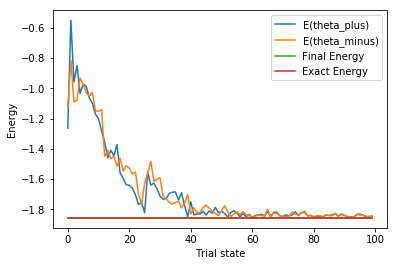

In [3]:
plt.plot(np.arange(0, max_trials,save_step),output[2],label='E(theta_plus)')
plt.plot(np.arange(0, max_trials,save_step),output[3],label='E(theta_minus)')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*output[0],label='Final Energy')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*exact,label='Exact Energy')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

## Optimizing the potential energy surface 

The optimization considered previously is now performed for two molecules, H$_2$ and LiH, for different interatomic distances, and the correspoding nuclei Coulomb repulsion is added in order to obtain a potential energy surface. 

In [8]:
# MOLECULE PARAMETERS

molecule='H2' # name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
# OPTIMIZATION PARAMETERS 

run_optimization=True # Choose True or False. False just plots the exact potential energy surface

m=2 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
initial_theta=np.random.randn(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=100

initial_c = 0.01
target_update = 2*np.pi*0.1
save_step = 1

####################     COMPUTING THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

for i in range(number_of_points):

    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic Molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        pauli_list=Hamiltonian_from_file(ham_text)
        H=make_Hamiltonian(pauli_list)
        pauli_list_grouped = group_paulis(pauli_list)
        eigen=la.eig(H)
        electr_energy[i]=np.amin(eigen[0])
           
    # optimization
    
        if run_optimization:
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE ' + str(mol_distance[i]) + ' ANGSTROM\n')
            eval_hamiltonian_partial=partial(eval_hamiltonian,Q_program,n,m,ham_name,device,shots,H)
            
            if shots !=1:
                H=group_paulis(pauli_list)
         
        
            SPSA_params = SPSA_calibration(partial(cost_function,Q_program,H,n,m,entangler_map,
                                           shots,device),initial_theta,initial_c,target_update,25)
            
            electr_energy_optimized[i] = SPSA_optimization(partial(cost_function,Q_program,H,n,m,entangler_map,shots,device),
                                                           initial_theta,SPSA_params,max_trials,save_step,1)[0];

    
    

/Users/amezzac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part



OPTIMIZING HAMILTONIAN # 0 AT INTERATOMIC DISTANCE 0.2 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 1.05693435903
objective function at theta+ for step # 0
0.806559599402
objective function at theta- for step # 0
0.822930447589
objective function at theta+ for step # 1
-0.551620580852
objective function at theta- for step # 1
-0.556567791247
objective function at theta+ for step # 2
-0.596039608082
objective function at theta- for step # 2
-0.594790331093
objective function at theta+ for step # 3
-0.589497033181
objective function at theta- for step # 3
-0.60665587279
objective function at theta+ for step # 4
-0.80716312194
objective function at theta- for step # 4
-0.824006826979
objective function at theta+ for step # 5
-1.08807338085
objective function at theta- for step # 5
-1.08078693171
objective function at theta+ for step # 6
-1.128144062
obje

objective function at theta+ for step # 69
-2.44801465742
objective function at theta- for step # 69
-2.44520434176
objective function at theta+ for step # 70
-2.4478858993
objective function at theta- for step # 70
-2.45161863893
objective function at theta+ for step # 71
-2.45555227084
objective function at theta- for step # 71
-2.45511654712
objective function at theta+ for step # 72
-2.45538678966
objective function at theta- for step # 72
-2.45570761166
objective function at theta+ for step # 73
-2.45300204807
objective function at theta- for step # 73
-2.45816311665
objective function at theta+ for step # 74
-2.46665596754
objective function at theta- for step # 74
-2.46579427533
objective function at theta+ for step # 75
-2.46634439961
objective function at theta- for step # 75
-2.46650723171
objective function at theta+ for step # 76
-2.46448494001
objective function at theta- for step # 76
-2.46835611129
objective function at theta+ for step # 77
-2.47053917424
objective funct

objective function at theta+ for step # 38
-2.34968991521
objective function at theta- for step # 38
-2.35565852744
objective function at theta+ for step # 39
-2.36104813479
objective function at theta- for step # 39
-2.36219996138
objective function at theta+ for step # 40
-2.36214674395
objective function at theta- for step # 40
-2.36256107116
objective function at theta+ for step # 41
-2.36349333185
objective function at theta- for step # 41
-2.36111892899
objective function at theta+ for step # 42
-2.36446181115
objective function at theta- for step # 42
-2.36342647251
objective function at theta+ for step # 43
-2.36449267172
objective function at theta- for step # 43
-2.36423890224
objective function at theta+ for step # 44
-2.36494607762
objective function at theta- for step # 44
-2.36359263434
objective function at theta+ for step # 45
-2.36503905209
objective function at theta- for step # 45
-2.36452754038
objective function at theta+ for step # 46
-2.36479184673
objective func

objective function at theta+ for step # 7
-0.368766027923
objective function at theta- for step # 7
-0.383759537684
objective function at theta+ for step # 8
-0.712503425268
objective function at theta- for step # 8
-0.710238129692
objective function at theta+ for step # 9
-0.719022461904
objective function at theta- for step # 9
-0.717630366655
objective function at theta+ for step # 10
-0.712354900717
objective function at theta- for step # 10
-0.729858014749
objective function at theta+ for step # 11
-1.05388080897
objective function at theta- for step # 11
-1.07371889731
objective function at theta+ for step # 12
-1.46922314483
objective function at theta- for step # 12
-1.46339085587
objective function at theta+ for step # 13
-1.47766337921
objective function at theta- for step # 13
-1.48415302733
objective function at theta+ for step # 14
-1.52499668222
objective function at theta- for step # 14
-1.52487889748
objective function at theta+ for step # 15
-1.52177277174
objective fu

objective function at theta+ for step # 78
-2.23651536106
objective function at theta- for step # 78
-2.2363852396
objective function at theta+ for step # 79
-2.23645831811
objective function at theta- for step # 79
-2.23644063281
objective function at theta+ for step # 80
-2.23642469587
objective function at theta- for step # 80
-2.23646868305
objective function at theta+ for step # 81
-2.23642635623
objective function at theta- for step # 81
-2.23648461463
objective function at theta+ for step # 82
-2.23659925353
objective function at theta- for step # 82
-2.23653031023
objective function at theta+ for step # 83
-2.23648122476
objective function at theta- for step # 83
-2.23642914158
objective function at theta+ for step # 84
-2.23653163587
objective function at theta- for step # 84
-2.23660579369
objective function at theta+ for step # 85
-2.2365426377
objective function at theta- for step # 85
-2.23659995987
objective function at theta+ for step # 86
-2.2365769496
objective functio

objective function at theta+ for step # 47
-2.09293455357
objective function at theta- for step # 47
-2.09368092475
objective function at theta+ for step # 48
-2.09380038191
objective function at theta- for step # 48
-2.09346745191
objective function at theta+ for step # 49
-2.09446674045
objective function at theta- for step # 49
-2.09271251353
objective function at theta+ for step # 50
-2.09553608095
objective function at theta- for step # 50
-2.09393503233
objective function at theta+ for step # 51
-2.0965378254
objective function at theta- for step # 51
-2.09501594172
objective function at theta+ for step # 52
-2.09641788321
objective function at theta- for step # 52
-2.09700626145
objective function at theta+ for step # 53
-2.0968851154
objective function at theta- for step # 53
-2.09701973377
objective function at theta+ for step # 54
-2.09647305028
objective function at theta- for step # 54
-2.09745626346
objective function at theta+ for step # 55
-2.09785493023
objective functi

objective function at theta+ for step # 16
-1.45275645365
objective function at theta- for step # 16
-1.45573728552
objective function at theta+ for step # 17
-1.45388210931
objective function at theta- for step # 17
-1.46479871862
objective function at theta+ for step # 18
-1.60348691759
objective function at theta- for step # 18
-1.60632381152
objective function at theta+ for step # 19
-1.61132643082
objective function at theta- for step # 19
-1.6056456431
objective function at theta+ for step # 20
-1.64654517044
objective function at theta- for step # 20
-1.6471067308
objective function at theta+ for step # 21
-1.64385597921
objective function at theta- for step # 21
-1.65065950472
objective function at theta+ for step # 22
-1.7005792045
objective function at theta- for step # 22
-1.69896238561
objective function at theta+ for step # 23
-1.70471854382
objective function at theta- for step # 23
-1.69999334353
objective function at theta+ for step # 24
-1.72024810203
objective functio

objective function at theta+ for step # 87
-1.99135234048
objective function at theta- for step # 87
-1.99121019333
objective function at theta+ for step # 88
-1.99134114628
objective function at theta- for step # 88
-1.99106970118
objective function at theta+ for step # 89
-1.99103502291
objective function at theta- for step # 89
-1.99143662939
objective function at theta+ for step # 90
-1.99104955836
objective function at theta- for step # 90
-1.99164899594
objective function at theta+ for step # 91
-1.99129482311
objective function at theta- for step # 91
-1.99174139898
objective function at theta+ for step # 92
-1.99142217669
objective function at theta- for step # 92
-1.99181460362
objective function at theta+ for step # 93
-1.99157200177
objective function at theta- for step # 93
-1.99185206608
objective function at theta+ for step # 94
-1.99177774623
objective function at theta- for step # 94
-1.99185269992
objective function at theta+ for step # 95
-1.99171412373
objective func

objective function at theta+ for step # 56
-1.88099240976
objective function at theta- for step # 56
-1.8810805004
objective function at theta+ for step # 57
-1.88102642771
objective function at theta- for step # 57
-1.88106350891
objective function at theta+ for step # 58
-1.88098327324
objective function at theta- for step # 58
-1.88093933797
objective function at theta+ for step # 59
-1.88146764887
objective function at theta- for step # 59
-1.88062601081
objective function at theta+ for step # 60
-1.88199218991
objective function at theta- for step # 60
-1.88148733933
objective function at theta+ for step # 61
-1.88175234855
objective function at theta- for step # 61
-1.881915584
objective function at theta+ for step # 62
-1.88183147941
objective function at theta- for step # 62
-1.88207242817
objective function at theta+ for step # 63
-1.8819296511
objective function at theta- for step # 63
-1.88191876112
objective function at theta+ for step # 64
-1.88190243183
objective function

objective function at theta+ for step # 25
-1.76896449564
objective function at theta- for step # 25
-1.77006362068
objective function at theta+ for step # 26
-1.76950266819
objective function at theta- for step # 26
-1.77068188072
objective function at theta+ for step # 27
-1.77173753508
objective function at theta- for step # 27
-1.7699038297
objective function at theta+ for step # 28
-1.77189417201
objective function at theta- for step # 28
-1.77464509033
objective function at theta+ for step # 29
-1.77823577454
objective function at theta- for step # 29
-1.7772097347
objective function at theta+ for step # 30
-1.77808108737
objective function at theta- for step # 30
-1.77870829898
objective function at theta+ for step # 31
-1.77805693433
objective function at theta- for step # 31
-1.77931156361
objective function at theta+ for step # 32
-1.77977288924
objective function at theta- for step # 32
-1.77969902622
objective function at theta+ for step # 33
-1.779583743
objective function

objective function at theta+ for step # 96
-1.79383589575
objective function at theta- for step # 96
-1.79356309161
objective function at theta+ for step # 97
-1.79379493881
objective function at theta- for step # 97
-1.79368633294
objective function at theta+ for step # 98
-1.79370997267
objective function at theta- for step # 98
-1.7937812529
objective function at theta+ for step # 99
-1.79399689082
objective function at theta- for step # 99
-1.79360724156
Final objective function is: -1.79390401869

OPTIMIZING HAMILTONIAN # 7 AT INTERATOMIC DISTANCE 0.9 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 3.72620971066
objective function at theta+ for step # 0
-0.524782728899
objective function at theta- for step # 0
-0.52968387086
objective function at theta+ for step # 1
-0.982004625405
objective function at theta- for step # 1
-0.98489553016
objective fu

objective function at theta+ for step # 65
-1.70065040953
objective function at theta- for step # 65
-1.70057278485
objective function at theta+ for step # 66
-1.70073297347
objective function at theta- for step # 66
-1.70054498296
objective function at theta+ for step # 67
-1.70064935089
objective function at theta- for step # 67
-1.70057932319
objective function at theta+ for step # 68
-1.70018854721
objective function at theta- for step # 68
-1.70107574358
objective function at theta+ for step # 69
-1.70129577649
objective function at theta- for step # 69
-1.70107870215
objective function at theta+ for step # 70
-1.7012706799
objective function at theta- for step # 70
-1.70130133207
objective function at theta+ for step # 71
-1.70133767654
objective function at theta- for step # 71
-1.70115275788
objective function at theta+ for step # 72
-1.70100125339
objective function at theta- for step # 72
-1.70164053737
objective function at theta+ for step # 73
-1.70169776512
objective funct

objective function at theta+ for step # 34
-1.57166001229
objective function at theta- for step # 34
-1.56998686635
objective function at theta+ for step # 35
-1.57473746326
objective function at theta- for step # 35
-1.57465480913
objective function at theta+ for step # 36
-1.5737320848
objective function at theta- for step # 36
-1.57566922302
objective function at theta+ for step # 37
-1.58171194257
objective function at theta- for step # 37
-1.58021574314
objective function at theta+ for step # 38
-1.58513040579
objective function at theta- for step # 38
-1.58557403858
objective function at theta+ for step # 39
-1.58594233504
objective function at theta- for step # 39
-1.58554372308
objective function at theta+ for step # 40
-1.58614207545
objective function at theta- for step # 40
-1.58595191221
objective function at theta+ for step # 41
-1.58541285935
objective function at theta- for step # 41
-1.586685393
objective function at theta+ for step # 42
-1.58641302981
objective functio

objective function at theta+ for step # 3
-0.77991611465
objective function at theta- for step # 3
-0.77904854205
objective function at theta+ for step # 4
-0.788162078365
objective function at theta- for step # 4
-0.786230275726
objective function at theta+ for step # 5
-0.870810281374
objective function at theta- for step # 5
-0.860246078124
objective function at theta+ for step # 6
-1.05846930477
objective function at theta- for step # 6
-1.04303413093
objective function at theta+ for step # 7
-0.774491015722
objective function at theta- for step # 7
-0.769096932891
objective function at theta+ for step # 8
-0.901907612988
objective function at theta- for step # 8
-0.903433063244
objective function at theta+ for step # 9
-0.921065801634
objective function at theta- for step # 9
-0.913383136515
objective function at theta+ for step # 10
-1.17678442984
objective function at theta- for step # 10
-1.17743886765
objective function at theta+ for step # 11
-1.1763917007
objective function 

objective function at theta+ for step # 74
-1.55966422452
objective function at theta- for step # 74
-1.55957775023
objective function at theta+ for step # 75
-1.55949854888
objective function at theta- for step # 75
-1.55963666072
objective function at theta+ for step # 76
-1.55961155293
objective function at theta- for step # 76
-1.55968600611
objective function at theta+ for step # 77
-1.55959225141
objective function at theta- for step # 77
-1.55963736769
objective function at theta+ for step # 78
-1.55979218667
objective function at theta- for step # 78
-1.55942132343
objective function at theta+ for step # 79
-1.55982796621
objective function at theta- for step # 79
-1.55971304948
objective function at theta+ for step # 80
-1.55988497704
objective function at theta- for step # 80
-1.55961241834
objective function at theta+ for step # 81
-1.55988610502
objective function at theta- for step # 81
-1.55984555121
objective function at theta+ for step # 82
-1.55982761164
objective func

objective function at theta+ for step # 43
-1.27012787232
objective function at theta- for step # 43
-1.27036701382
objective function at theta+ for step # 44
-1.27040023317
objective function at theta- for step # 44
-1.27024677249
objective function at theta+ for step # 45
-1.27035695694
objective function at theta- for step # 45
-1.27038823229
objective function at theta+ for step # 46
-1.27024124373
objective function at theta- for step # 46
-1.27053773835
objective function at theta+ for step # 47
-1.27054799629
objective function at theta- for step # 47
-1.27052110146
objective function at theta+ for step # 48
-1.27048952109
objective function at theta- for step # 48
-1.27054848789
objective function at theta+ for step # 49
-1.27057477629
objective function at theta- for step # 49
-1.27048051905
objective function at theta+ for step # 50
-1.2704054316
objective function at theta- for step # 50
-1.27064636424
objective function at theta+ for step # 51
-1.27068776727
objective funct

objective function at theta+ for step # 11
-1.3175528334
objective function at theta- for step # 11
-1.31558784165
objective function at theta+ for step # 12
-1.32289955102
objective function at theta- for step # 12
-1.31992765779
objective function at theta+ for step # 13
-1.33589861801
objective function at theta- for step # 13
-1.33575317457
objective function at theta+ for step # 14
-1.3356679983
objective function at theta- for step # 14
-1.33599871
objective function at theta+ for step # 15
-1.33524359063
objective function at theta- for step # 15
-1.33672658181
objective function at theta+ for step # 16
-1.33751397308
objective function at theta- for step # 16
-1.3411004887
objective function at theta+ for step # 17
-1.34043644368
objective function at theta- for step # 17
-1.34446629206
objective function at theta+ for step # 18
-1.352134723
objective function at theta- for step # 18
-1.35380003353
objective function at theta+ for step # 19
-1.35744172557
objective function at 

objective function at theta+ for step # 82
-1.40453441967
objective function at theta- for step # 82
-1.40323563842
objective function at theta+ for step # 83
-1.40508909849
objective function at theta- for step # 83
-1.4054239976
objective function at theta+ for step # 84
-1.4049987891
objective function at theta- for step # 84
-1.40571712805
objective function at theta+ for step # 85
-1.40524407834
objective function at theta- for step # 85
-1.40631400394
objective function at theta+ for step # 86
-1.40685348618
objective function at theta- for step # 86
-1.40652575142
objective function at theta+ for step # 87
-1.40714101003
objective function at theta- for step # 87
-1.40635892487
objective function at theta+ for step # 88
-1.40804362247
objective function at theta- for step # 88
-1.40638124645
objective function at theta+ for step # 89
-1.40897584565
objective function at theta- for step # 89
-1.40977779045
objective function at theta+ for step # 90
-1.40976450469
objective functi

objective function at theta+ for step # 51
-1.36364340346
objective function at theta- for step # 51
-1.36242745253
objective function at theta+ for step # 52
-1.36528108093
objective function at theta- for step # 52
-1.36589282276
objective function at theta+ for step # 53
-1.36588558739
objective function at theta- for step # 53
-1.36655799769
objective function at theta+ for step # 54
-1.36654699486
objective function at theta- for step # 54
-1.36691701005
objective function at theta+ for step # 55
-1.36696043122
objective function at theta- for step # 55
-1.36691641734
objective function at theta+ for step # 56
-1.36660428977
objective function at theta- for step # 56
-1.36728396276
objective function at theta+ for step # 57
-1.36743315265
objective function at theta- for step # 57
-1.3679923993
objective function at theta+ for step # 58
-1.36814620263
objective function at theta- for step # 58
-1.3679499161
objective function at theta+ for step # 59
-1.36844767605
objective functi

objective function at theta+ for step # 20
-1.2648002211
objective function at theta- for step # 20
-1.25892802437
objective function at theta+ for step # 21
-1.21889312332
objective function at theta- for step # 21
-1.21926490088
objective function at theta+ for step # 22
-1.21984877745
objective function at theta- for step # 22
-1.21937835944
objective function at theta+ for step # 23
-1.21874866684
objective function at theta- for step # 23
-1.22201496083
objective function at theta+ for step # 24
-1.23710935812
objective function at theta- for step # 24
-1.23369597677
objective function at theta+ for step # 25
-1.26790662214
objective function at theta- for step # 25
-1.26518470085
objective function at theta+ for step # 26
-1.282969305
objective function at theta- for step # 26
-1.28030942283
objective function at theta+ for step # 27
-1.29557182471
objective function at theta- for step # 27
-1.29359551538
objective function at theta+ for step # 28
-1.30359143122
objective functio

objective function at theta+ for step # 91
-1.34367782746
objective function at theta- for step # 91
-1.34344457422
objective function at theta+ for step # 92
-1.34362456664
objective function at theta- for step # 92
-1.34364301119
objective function at theta+ for step # 93
-1.34352178467
objective function at theta- for step # 93
-1.34374759254
objective function at theta+ for step # 94
-1.34360122334
objective function at theta- for step # 94
-1.3438513467
objective function at theta+ for step # 95
-1.34382027439
objective function at theta- for step # 95
-1.34377921799
objective function at theta+ for step # 96
-1.34389278794
objective function at theta- for step # 96
-1.34380021226
objective function at theta+ for step # 97
-1.34366729191
objective function at theta- for step # 97
-1.34402049382
objective function at theta+ for step # 98
-1.3441332985
objective function at theta- for step # 98
-1.34386647975
objective function at theta+ for step # 99
-1.34442189989
objective functi

objective function at theta+ for step # 60
-1.24494185076
objective function at theta- for step # 60
-1.24408525157
objective function at theta+ for step # 61
-1.2455400195
objective function at theta- for step # 61
-1.24563572632
objective function at theta+ for step # 62
-1.24566756256
objective function at theta- for step # 62
-1.2454804473
objective function at theta+ for step # 63
-1.24544584139
objective function at theta- for step # 63
-1.2458613145
objective function at theta+ for step # 64
-1.24584535986
objective function at theta- for step # 64
-1.24600167562
objective function at theta+ for step # 65
-1.24619724194
objective function at theta- for step # 65
-1.24573341285
objective function at theta+ for step # 66
-1.24664353794
objective function at theta- for step # 66
-1.245943597
objective function at theta+ for step # 67
-1.24670909465
objective function at theta- for step # 67
-1.24737190814
objective function at theta+ for step # 68
-1.24784419886
objective function 

objective function at theta+ for step # 29
-1.23211349249
objective function at theta- for step # 29
-1.23148964116
objective function at theta+ for step # 30
-1.23291253882
objective function at theta- for step # 30
-1.23222292236
objective function at theta+ for step # 31
-1.2335583543
objective function at theta- for step # 31
-1.2331016948
objective function at theta+ for step # 32
-1.23388168771
objective function at theta- for step # 32
-1.23345512906
objective function at theta+ for step # 33
-1.23357722793
objective function at theta- for step # 33
-1.23443496497
objective function at theta+ for step # 34
-1.23496113224
objective function at theta- for step # 34
-1.23543656304
objective function at theta+ for step # 35
-1.23524167298
objective function at theta- for step # 35
-1.23586872867
objective function at theta+ for step # 36
-1.23637224589
objective function at theta- for step # 36
-1.23594775163
objective function at theta+ for step # 37
-1.2360051089
objective functio

calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 4.34256170226
objective function at theta+ for step # 0
-0.729359762536
objective function at theta- for step # 0
-0.738198019347
objective function at theta+ for step # 1
-1.1126809304
objective function at theta- for step # 1
-1.12231404537
objective function at theta+ for step # 2
-0.868789659071
objective function at theta- for step # 2
-0.864821242144
objective function at theta+ for step # 3
-0.981789542146
objective function at theta- for step # 3
-0.979324910507
objective function at theta+ for step # 4
-0.990088981777
objective function at theta- for step # 4
-0.988355072959
objective function at theta+ for step # 5
-0.996205895088
objective function at theta- for step # 5
-0.989126452869
objective function at theta+ for step # 6
-1.1318623052
objective function at theta- for step # 6
-1.13174724331
objective function at theta+ for ste

objective function at theta+ for step # 70
-1.22520476957
objective function at theta- for step # 70
-1.22494151691
objective function at theta+ for step # 71
-1.22518944782
objective function at theta- for step # 71
-1.22512408926
objective function at theta+ for step # 72
-1.22531536555
objective function at theta- for step # 72
-1.2250266083
objective function at theta+ for step # 73
-1.22515423771
objective function at theta- for step # 73
-1.22541449641
objective function at theta+ for step # 74
-1.22521250264
objective function at theta- for step # 74
-1.22558478507
objective function at theta+ for step # 75
-1.22581494584
objective function at theta- for step # 75
-1.22543027263
objective function at theta+ for step # 76
-1.22569893779
objective function at theta- for step # 76
-1.22603153499
objective function at theta+ for step # 77
-1.22591148476
objective function at theta- for step # 77
-1.22621577121
objective function at theta+ for step # 78
-1.22620712195
objective funct

objective function at theta+ for step # 38
-1.20966929237
objective function at theta- for step # 38
-1.20940051304
objective function at theta+ for step # 39
-1.20949231433
objective function at theta- for step # 39
-1.20982095443
objective function at theta+ for step # 40
-1.20974778214
objective function at theta- for step # 40
-1.20982900895
objective function at theta+ for step # 41
-1.20987222031
objective function at theta- for step # 41
-1.20976165777
objective function at theta+ for step # 42
-1.20969642906
objective function at theta- for step # 42
-1.20997366275
objective function at theta+ for step # 43
-1.20975543023
objective function at theta- for step # 43
-1.21012166489
objective function at theta+ for step # 44
-1.21006505616
objective function at theta- for step # 44
-1.21005289823
objective function at theta+ for step # 45
-1.20994742409
objective function at theta- for step # 45
-1.21018608906
objective function at theta+ for step # 46
-1.21026101836
objective func

objective function at theta+ for step # 7
-1.11386089154
objective function at theta- for step # 7
-1.11116570837
objective function at theta+ for step # 8
-1.12801636613
objective function at theta- for step # 8
-1.1259814225
objective function at theta+ for step # 9
-1.12532518206
objective function at theta- for step # 9
-1.11779356984
objective function at theta+ for step # 10
-1.18278137891
objective function at theta- for step # 10
-1.18235234671
objective function at theta+ for step # 11
-1.18312867486
objective function at theta- for step # 11
-1.18284413065
objective function at theta+ for step # 12
-1.18340890358
objective function at theta- for step # 12
-1.18298557088
objective function at theta+ for step # 13
-1.18324041299
objective function at theta- for step # 13
-1.18406600117
objective function at theta+ for step # 14
-1.18384774145
objective function at theta- for step # 14
-1.1862628737
objective function at theta+ for step # 15
-1.19499980682
objective function at 

objective function at theta+ for step # 78
-1.20833098718
objective function at theta- for step # 78
-1.20851383589
objective function at theta+ for step # 79
-1.2083966839
objective function at theta- for step # 79
-1.20850309731
objective function at theta+ for step # 80
-1.2085515611
objective function at theta- for step # 80
-1.20839820594
objective function at theta+ for step # 81
-1.20843845744
objective function at theta- for step # 81
-1.20852161769
objective function at theta+ for step # 82
-1.20848979597
objective function at theta- for step # 82
-1.20847993828
objective function at theta+ for step # 83
-1.20841073882
objective function at theta- for step # 83
-1.20864569865
objective function at theta+ for step # 84
-1.20848607403
objective function at theta- for step # 84
-1.20863554616
objective function at theta+ for step # 85
-1.20845271196
objective function at theta- for step # 85
-1.20868084728
objective function at theta+ for step # 86
-1.20859908997
objective functi

objective function at theta+ for step # 47
-1.17894189421
objective function at theta- for step # 47
-1.17896054514
objective function at theta+ for step # 48
-1.17892534626
objective function at theta- for step # 48
-1.17897294555
objective function at theta+ for step # 49
-1.17894614254
objective function at theta- for step # 49
-1.17888411264
objective function at theta+ for step # 50
-1.17897062789
objective function at theta- for step # 50
-1.17897318596
objective function at theta+ for step # 51
-1.17894087813
objective function at theta- for step # 51
-1.17896921306
objective function at theta+ for step # 52
-1.17895639708
objective function at theta- for step # 52
-1.17895377475
objective function at theta+ for step # 53
-1.17895464668
objective function at theta- for step # 53
-1.17895598334
objective function at theta+ for step # 54
-1.17895809062
objective function at theta- for step # 54
-1.17896377281
objective function at theta+ for step # 55
-1.17897755978
objective func

objective function at theta+ for step # 16
-1.17018345336
objective function at theta- for step # 16
-1.17008450095
objective function at theta+ for step # 17
-1.17014855971
objective function at theta- for step # 17
-1.17015178823
objective function at theta+ for step # 18
-1.17015646382
objective function at theta- for step # 18
-1.17018357711
objective function at theta+ for step # 19
-1.17016126064
objective function at theta- for step # 19
-1.17018274857
objective function at theta+ for step # 20
-1.1702187146
objective function at theta- for step # 20
-1.1699616466
objective function at theta+ for step # 21
-1.17017838044
objective function at theta- for step # 21
-1.17020434906
objective function at theta+ for step # 22
-1.17006796147
objective function at theta- for step # 22
-1.17018454633
objective function at theta+ for step # 23
-1.17026183822
objective function at theta- for step # 23
-1.17018743769
objective function at theta+ for step # 24
-1.1701858179
objective functio

objective function at theta+ for step # 87
-1.17053068167
objective function at theta- for step # 87
-1.17059787654
objective function at theta+ for step # 88
-1.17049769043
objective function at theta- for step # 88
-1.17052388051
objective function at theta+ for step # 89
-1.17060564969
objective function at theta- for step # 89
-1.17052057039
objective function at theta+ for step # 90
-1.17059416666
objective function at theta- for step # 90
-1.17055410437
objective function at theta+ for step # 91
-1.17060621472
objective function at theta- for step # 91
-1.17055410889
objective function at theta+ for step # 92
-1.17053234049
objective function at theta- for step # 92
-1.17065249507
objective function at theta+ for step # 93
-1.17056524675
objective function at theta- for step # 93
-1.17064346069
objective function at theta+ for step # 94
-1.17066241167
objective function at theta- for step # 94
-1.17052708743
objective function at theta+ for step # 95
-1.17064317943
objective func

objective function at theta+ for step # 56
-1.1617861011
objective function at theta- for step # 56
-1.16191071623
objective function at theta+ for step # 57
-1.16193778386
objective function at theta- for step # 57
-1.16191178377
objective function at theta+ for step # 58
-1.16190258781
objective function at theta- for step # 58
-1.16189643431
objective function at theta+ for step # 59
-1.16179697909
objective function at theta- for step # 59
-1.161945184
objective function at theta+ for step # 60
-1.16199489496
objective function at theta- for step # 60
-1.16184328633
objective function at theta+ for step # 61
-1.16194509833
objective function at theta- for step # 61
-1.16194495458
objective function at theta+ for step # 62
-1.16193872883
objective function at theta- for step # 62
-1.16200456194
objective function at theta+ for step # 63
-1.16204156315
objective function at theta- for step # 63
-1.1618557765
objective function at theta+ for step # 64
-1.16195669036
objective function

objective function at theta+ for step # 25
-1.15613645057
objective function at theta- for step # 25
-1.15641924499
objective function at theta+ for step # 26
-1.15668179258
objective function at theta- for step # 26
-1.15601936144
objective function at theta+ for step # 27
-1.15671997523
objective function at theta- for step # 27
-1.15678373328
objective function at theta+ for step # 28
-1.15684732416
objective function at theta- for step # 28
-1.15680117605
objective function at theta+ for step # 29
-1.15648715221
objective function at theta- for step # 29
-1.15707753976
objective function at theta+ for step # 30
-1.15713965772
objective function at theta- for step # 30
-1.15710895319
objective function at theta+ for step # 31
-1.15721241063
objective function at theta- for step # 31
-1.15701907355
objective function at theta+ for step # 32
-1.15729075454
objective function at theta- for step # 32
-1.15702381209
objective function at theta+ for step # 33
-1.15722303281
objective func

objective function at theta+ for step # 96
-1.15734380495
objective function at theta- for step # 96
-1.15739549944
objective function at theta+ for step # 97
-1.15738078093
objective function at theta- for step # 97
-1.15735283254
objective function at theta+ for step # 98
-1.15733575991
objective function at theta- for step # 98
-1.15735264356
objective function at theta+ for step # 99
-1.15736119173
objective function at theta- for step # 99
-1.15737807461
Final objective function is: -1.15739157844

OPTIMIZING HAMILTONIAN # 23 AT INTERATOMIC DISTANCE 2.5 ANGSTROM

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 2.60724717705
objective function at theta+ for step # 0
-0.705474338368
objective function at theta- for step # 0
-0.699851923572
objective function at theta+ for step # 1
-0.687155849905
objective function at theta- for step # 1
-0.692209602176
objectiv

objective function at theta+ for step # 65
-1.14319418228
objective function at theta- for step # 65
-1.14336165326
objective function at theta+ for step # 66
-1.14326349044
objective function at theta- for step # 66
-1.14328469553
objective function at theta+ for step # 67
-1.14313118257
objective function at theta- for step # 67
-1.14341574463
objective function at theta+ for step # 68
-1.14335945114
objective function at theta- for step # 68
-1.14340661264
objective function at theta+ for step # 69
-1.14337835704
objective function at theta- for step # 69
-1.14341060567
objective function at theta+ for step # 70
-1.14332370864
objective function at theta- for step # 70
-1.14345152882
objective function at theta+ for step # 71
-1.14329936082
objective function at theta- for step # 71
-1.14333874799
objective function at theta+ for step # 72
-1.14349263249
objective function at theta- for step # 72
-1.14328637531
objective function at theta+ for step # 73
-1.14353365164
objective func

objective function at theta+ for step # 33
-1.13565392336
objective function at theta- for step # 33
-1.1357244873
objective function at theta+ for step # 34
-1.13564779628
objective function at theta- for step # 34
-1.13576853452
objective function at theta+ for step # 35
-1.1357228247
objective function at theta- for step # 35
-1.1357468823
objective function at theta+ for step # 36
-1.13573544134
objective function at theta- for step # 36
-1.13574013311
objective function at theta+ for step # 37
-1.13577177749
objective function at theta- for step # 37
-1.13565903668
objective function at theta+ for step # 38
-1.13564337916
objective function at theta- for step # 38
-1.13568544492
objective function at theta+ for step # 39
-1.13570185197
objective function at theta- for step # 39
-1.13577313806
objective function at theta+ for step # 40
-1.13571634781
objective function at theta- for step # 40
-1.13565556241
objective function at theta+ for step # 41
-1.13574723321
objective functio

objective function at theta+ for step # 2
-0.940584049425
objective function at theta- for step # 2
-0.937454840614
objective function at theta+ for step # 3
-0.945728479311
objective function at theta- for step # 3
-0.944649276437
objective function at theta+ for step # 4
-0.952677699593
objective function at theta- for step # 4
-0.943747256751
objective function at theta+ for step # 5
-1.06277135403
objective function at theta- for step # 5
-1.0594543184
objective function at theta+ for step # 6
-1.0861476869
objective function at theta- for step # 6
-1.08544715245
objective function at theta+ for step # 7
-1.08646527602
objective function at theta- for step # 7
-1.08723172256
objective function at theta+ for step # 8
-1.08643726098
objective function at theta- for step # 8
-1.08721779587
objective function at theta+ for step # 9
-1.08534809713
objective function at theta- for step # 9
-1.08857140662
objective function at theta+ for step # 10
-1.10023536844
objective function at thet

objective function at theta+ for step # 73
-1.12805489536
objective function at theta- for step # 73
-1.12790653644
objective function at theta+ for step # 74
-1.12809073937
objective function at theta- for step # 74
-1.128001516
objective function at theta+ for step # 75
-1.12802356638
objective function at theta- for step # 75
-1.12808858005
objective function at theta+ for step # 76
-1.12818304076
objective function at theta- for step # 76
-1.12797407937
objective function at theta+ for step # 77
-1.12806461526
objective function at theta- for step # 77
-1.12813003127
objective function at theta+ for step # 78
-1.12810969931
objective function at theta- for step # 78
-1.12808290367
objective function at theta+ for step # 79
-1.12820673888
objective function at theta- for step # 79
-1.12806241424
objective function at theta+ for step # 80
-1.12818161536
objective function at theta- for step # 80
-1.12808529674
objective function at theta+ for step # 81
-1.12803407826
objective functi

objective function at theta+ for step # 42
-1.1227182883
objective function at theta- for step # 42
-1.12268504313
objective function at theta+ for step # 43
-1.12266455219
objective function at theta- for step # 43
-1.12271169677
objective function at theta+ for step # 44
-1.12274670495
objective function at theta- for step # 44
-1.12274504961
objective function at theta+ for step # 45
-1.12268055015
objective function at theta- for step # 45
-1.12271669068
objective function at theta+ for step # 46
-1.12271166984
objective function at theta- for step # 46
-1.12272205964
objective function at theta+ for step # 47
-1.12268606187
objective function at theta- for step # 47
-1.12266900125
objective function at theta+ for step # 48
-1.12267633652
objective function at theta- for step # 48
-1.12268312592
objective function at theta+ for step # 49
-1.12272311064
objective function at theta- for step # 49
-1.12270279457
objective function at theta+ for step # 50
-1.1227070553
objective functi

objective function at theta+ for step # 11
-1.11344122458
objective function at theta- for step # 11
-1.11221897227
objective function at theta+ for step # 12
-1.11341166851
objective function at theta- for step # 12
-1.11354323996
objective function at theta+ for step # 13
-1.11313472664
objective function at theta- for step # 13
-1.11387619019
objective function at theta+ for step # 14
-1.11436996592
objective function at theta- for step # 14
-1.11436406922
objective function at theta+ for step # 15
-1.11414673956
objective function at theta- for step # 15
-1.11452565869
objective function at theta+ for step # 16
-1.11455608575
objective function at theta- for step # 16
-1.11440879424
objective function at theta+ for step # 17
-1.11451599122
objective function at theta- for step # 17
-1.11465419668
objective function at theta+ for step # 18
-1.11467781536
objective function at theta- for step # 18
-1.11449120113
objective function at theta+ for step # 19
-1.11467682297
objective func

objective function at theta+ for step # 82
-1.11506776863
objective function at theta- for step # 82
-1.11512214047
objective function at theta+ for step # 83
-1.11507580379
objective function at theta- for step # 83
-1.11511958571
objective function at theta+ for step # 84
-1.11508410224
objective function at theta- for step # 84
-1.11511246015
objective function at theta+ for step # 85
-1.11517363856
objective function at theta- for step # 85
-1.11507092661
objective function at theta+ for step # 86
-1.11513316845
objective function at theta- for step # 86
-1.11513220295
objective function at theta+ for step # 87
-1.11510530184
objective function at theta- for step # 87
-1.11511313341
objective function at theta+ for step # 88
-1.11512234236
objective function at theta- for step # 88
-1.11513999886
objective function at theta+ for step # 89
-1.11510515749
objective function at theta- for step # 89
-1.11503294996
objective function at theta+ for step # 90
-1.11513497735
objective func

-1.10994357697
objective function at theta- for step # 51
-1.10995909711
objective function at theta+ for step # 52
-1.11001118069
objective function at theta- for step # 52
-1.11001349203
objective function at theta+ for step # 53
-1.1100231041
objective function at theta- for step # 53
-1.11002314034
objective function at theta+ for step # 54
-1.11000549015
objective function at theta- for step # 54
-1.11000392367
objective function at theta+ for step # 55
-1.1099922041
objective function at theta- for step # 55
-1.10999449857
objective function at theta+ for step # 56
-1.10998035621
objective function at theta- for step # 56
-1.10997846238
objective function at theta+ for step # 57
-1.10999755074
objective function at theta- for step # 57
-1.10999627615
objective function at theta+ for step # 58
-1.10999702343
objective function at theta- for step # 58
-1.10999583349
objective function at theta+ for step # 59
-1.1100231288
objective function at theta- for step # 59
-1.11002287243
ob

objective function at theta+ for step # 21
-1.10378961269
objective function at theta- for step # 21
-1.10363881217
objective function at theta+ for step # 22
-1.10358626157
objective function at theta- for step # 22
-1.10377721288
objective function at theta+ for step # 23
-1.10378017922
objective function at theta- for step # 23
-1.10370594714
objective function at theta+ for step # 24
-1.10376723174
objective function at theta- for step # 24
-1.10364248335
objective function at theta+ for step # 25
-1.10378671101
objective function at theta- for step # 25
-1.10375557694
objective function at theta+ for step # 26
-1.10378786405
objective function at theta- for step # 26
-1.10377475694
objective function at theta+ for step # 27
-1.10380319542
objective function at theta- for step # 27
-1.10378956796
objective function at theta+ for step # 28
-1.10376679819
objective function at theta- for step # 28
-1.1037921029
objective function at theta+ for step # 29
-1.10378491806
objective funct

-1.10378945616
objective function at theta+ for step # 92
-1.10379998384
objective function at theta- for step # 92
-1.10380137149
objective function at theta+ for step # 93
-1.10378556848
objective function at theta- for step # 93
-1.10378822105
objective function at theta+ for step # 94
-1.10378798639
objective function at theta- for step # 94
-1.10378591765
objective function at theta+ for step # 95
-1.10377462888
objective function at theta- for step # 95
-1.10377664803
objective function at theta+ for step # 96
-1.10375027286
objective function at theta- for step # 96
-1.10375200637
objective function at theta+ for step # 97
-1.10378692165
objective function at theta- for step # 97
-1.10378658968
objective function at theta+ for step # 98
-1.10378207727
objective function at theta- for step # 98
-1.10378395935
objective function at theta+ for step # 99
-1.10378054038
objective function at theta- for step # 99
-1.10378036691
Final objective function is: -1.10380923316

OPTIMIZING H

objective function at theta+ for step # 61
-1.09840754771
objective function at theta- for step # 61
-1.09840889101
objective function at theta+ for step # 62
-1.09839862026
objective function at theta- for step # 62
-1.09839935654
objective function at theta+ for step # 63
-1.0984438549
objective function at theta- for step # 63
-1.09844658343
objective function at theta+ for step # 64
-1.09844280819
objective function at theta- for step # 64
-1.09844395875
objective function at theta+ for step # 65
-1.09845432291
objective function at theta- for step # 65
-1.09845592807
objective function at theta+ for step # 66
-1.09844464707
objective function at theta- for step # 66
-1.09844485098
objective function at theta+ for step # 67
-1.09846616543
objective function at theta- for step # 67
-1.09846629814
objective function at theta+ for step # 68
-1.098402248
objective function at theta- for step # 68
-1.09840247204
objective function at theta+ for step # 69
-1.09846452211
objective functio

objective function at theta- for step # 29
-1.09339362191
objective function at theta+ for step # 30
-1.09332811992
objective function at theta- for step # 30
-1.09349343278
objective function at theta+ for step # 31
-1.09351953343
objective function at theta- for step # 31
-1.09335600271
objective function at theta+ for step # 32
-1.09352099319
objective function at theta- for step # 32
-1.09343033449
objective function at theta+ for step # 33
-1.09353167138
objective function at theta- for step # 33
-1.09349821845
objective function at theta+ for step # 34
-1.09355573959
objective function at theta- for step # 34
-1.09346393001
objective function at theta+ for step # 35
-1.09353326659
objective function at theta- for step # 35
-1.09346142282
objective function at theta+ for step # 36
-1.09348462548
objective function at theta- for step # 36
-1.09352596144
objective function at theta+ for step # 37
-1.09349758732
objective function at theta- for step # 37
-1.09351413249
objective func

calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 1.96996135357
objective function at theta+ for step # 0
-0.649691137402
objective function at theta- for step # 0
-0.635395563591
objective function at theta+ for step # 1
-0.899519043871
objective function at theta- for step # 1
-0.888878515502
objective function at theta+ for step # 2
-1.03413112625
objective function at theta- for step # 2
-1.03080573231
objective function at theta+ for step # 3
-1.05762536534
objective function at theta- for step # 3
-1.05041904973
objective function at theta+ for step # 4
-1.05430709638
objective function at theta- for step # 4
-1.05524862355
objective function at theta+ for step # 5
-1.05956101678
objective function at theta- for step # 5
-1.05397253509
objective function at theta+ for step # 6
-1.05772968736
objective function at theta- for step # 6
-1.0607608038
objective function at theta+ for step # 7

objective function at theta+ for step # 70
-1.08820734661
objective function at theta- for step # 70
-1.088175048
objective function at theta+ for step # 71
-1.08811863766
objective function at theta- for step # 71
-1.08825009891
objective function at theta+ for step # 72
-1.08818259471
objective function at theta- for step # 72
-1.08826566421
objective function at theta+ for step # 73
-1.08823406366
objective function at theta- for step # 73
-1.08817964264
objective function at theta+ for step # 74
-1.08821464736
objective function at theta- for step # 74
-1.08823533053
objective function at theta+ for step # 75
-1.08824228971
objective function at theta- for step # 75
-1.0881849031
objective function at theta+ for step # 76
-1.08823800009
objective function at theta- for step # 76
-1.08821933673
objective function at theta+ for step # 77
-1.08816482785
objective function at theta- for step # 77
-1.08826020873
objective function at theta+ for step # 78
-1.08820721949
objective functio

objective function at theta+ for step # 39
-1.08434490852
objective function at theta- for step # 39
-1.08431993996
objective function at theta+ for step # 40
-1.08434695867
objective function at theta- for step # 40
-1.08433149346
objective function at theta+ for step # 41
-1.08426209149
objective function at theta- for step # 41
-1.08429938775
objective function at theta+ for step # 42
-1.08422102321
objective function at theta- for step # 42
-1.08424072424
objective function at theta+ for step # 43
-1.0843560962
objective function at theta- for step # 43
-1.0843549594
objective function at theta+ for step # 44
-1.08427389518
objective function at theta- for step # 44
-1.08426821006
objective function at theta+ for step # 45
-1.08434986911
objective function at theta- for step # 45
-1.08434697048
objective function at theta+ for step # 46
-1.08430972616
objective function at theta- for step # 46
-1.08431652785
objective function at theta+ for step # 47
-1.08433426745
objective functi

objective function at theta+ for step # 8
-0.75391423893
objective function at theta- for step # 8
-0.748189709509
objective function at theta+ for step # 9
-0.859538985771
objective function at theta- for step # 9
-0.864086181935
objective function at theta+ for step # 10
-0.91639686711
objective function at theta- for step # 10
-0.915361618961
objective function at theta+ for step # 11
-0.915113074528
objective function at theta- for step # 11
-0.920756633008
objective function at theta+ for step # 12
-0.956262859996
objective function at theta- for step # 12
-0.948550742387
objective function at theta+ for step # 13
-1.04630774629
objective function at theta- for step # 13
-1.04598737853
objective function at theta+ for step # 14
-1.04609336454
objective function at theta- for step # 14
-1.04650656826
objective function at theta+ for step # 15
-1.04606941567
objective function at theta- for step # 15
-1.04714417368
objective function at theta+ for step # 16
-1.04896243873
objective 

objective function at theta+ for step # 79
-1.08009611348
objective function at theta- for step # 79
-1.0801079841
objective function at theta+ for step # 80
-1.08011272559
objective function at theta- for step # 80
-1.08011137431
objective function at theta+ for step # 81
-1.08011273176
objective function at theta- for step # 81
-1.08011144315
objective function at theta+ for step # 82
-1.08010790949
objective function at theta- for step # 82
-1.08009041534
objective function at theta+ for step # 83
-1.08009174298
objective function at theta- for step # 83
-1.0800712135
objective function at theta+ for step # 84
-1.08009161389
objective function at theta- for step # 84
-1.08009112903
objective function at theta+ for step # 85
-1.08007085191
objective function at theta- for step # 85
-1.08009915219
objective function at theta+ for step # 86
-1.08013066626
objective function at theta- for step # 86
-1.08011985282
objective function at theta+ for step # 87
-1.08005426879
objective functi

objective function at theta+ for step # 47
-1.07617240731
objective function at theta- for step # 47
-1.07614497096
objective function at theta+ for step # 48
-1.07613180658
objective function at theta- for step # 48
-1.07610978974
objective function at theta+ for step # 49
-1.07619548698
objective function at theta- for step # 49
-1.07620041156
objective function at theta+ for step # 50
-1.07617648307
objective function at theta- for step # 50
-1.07618357278
objective function at theta+ for step # 51
-1.07617203866
objective function at theta- for step # 51
-1.07617076638
objective function at theta+ for step # 52
-1.07616878934
objective function at theta- for step # 52
-1.0761688495
objective function at theta+ for step # 53
-1.07618308024
objective function at theta- for step # 53
-1.07617770864
objective function at theta+ for step # 54
-1.07616776692
objective function at theta- for step # 54
-1.07616776516
objective function at theta+ for step # 55
-1.07615486435
objective funct

-1.07079923772
objective function at theta+ for step # 16
-1.07080260021
objective function at theta- for step # 16
-1.0707998611
objective function at theta+ for step # 17
-1.07158053165
objective function at theta- for step # 17
-1.06968987148
objective function at theta+ for step # 18
-1.07039858747
objective function at theta- for step # 18
-1.07040348246
objective function at theta+ for step # 19
-1.06978133712
objective function at theta- for step # 19
-1.07089512689
objective function at theta+ for step # 20
-1.07140737706
objective function at theta- for step # 20
-1.07167779875
objective function at theta+ for step # 21
-1.07132989153
objective function at theta- for step # 21
-1.07193133673
objective function at theta+ for step # 22
-1.07159359268
objective function at theta- for step # 22
-1.07221409039
objective function at theta+ for step # 23
-1.07196055018
objective function at theta- for step # 23
-1.07204316801
objective function at theta+ for step # 24
-1.07220468048


objective function at theta+ for step # 87
-1.07233803024
objective function at theta- for step # 87
-1.07233815725
objective function at theta+ for step # 88
-1.07238162894
objective function at theta- for step # 88
-1.07238218722
objective function at theta+ for step # 89
-1.072349982
objective function at theta- for step # 89
-1.07234981717
objective function at theta+ for step # 90
-1.07235973873
objective function at theta- for step # 90
-1.07235962338
objective function at theta+ for step # 91
-1.07238905521
objective function at theta- for step # 91
-1.07238932288
objective function at theta+ for step # 92
-1.0724061619
objective function at theta- for step # 92
-1.07240605715
objective function at theta+ for step # 93
-1.07239021528
objective function at theta- for step # 93
-1.0723899694
objective function at theta+ for step # 94
-1.0724060755
objective function at theta- for step # 94
-1.07240616774
objective function at theta+ for step # 95
-1.0724088104
objective function a

objective function at theta+ for step # 56
-1.06877619297
objective function at theta- for step # 56
-1.06876883
objective function at theta+ for step # 57
-1.06868613999
objective function at theta- for step # 57
-1.06869374808
objective function at theta+ for step # 58
-1.06884249735
objective function at theta- for step # 58
-1.06882754928
objective function at theta+ for step # 59
-1.06880524444
objective function at theta- for step # 59
-1.06882072698
objective function at theta+ for step # 60
-1.06880015388
objective function at theta- for step # 60
-1.0688080686
objective function at theta+ for step # 61
-1.06877625415
objective function at theta- for step # 61
-1.06877757147
objective function at theta+ for step # 62
-1.06881257729
objective function at theta- for step # 62
-1.06880449383
objective function at theta+ for step # 63
-1.06881910314
objective function at theta- for step # 63
-1.06881503559
objective function at theta+ for step # 64
-1.06884090238
objective function

objective function at theta+ for step # 25
-1.06270728617
objective function at theta- for step # 25
-1.06257904223
objective function at theta+ for step # 26
-1.06257965326
objective function at theta- for step # 26
-1.06278220284
objective function at theta+ for step # 27
-1.06275161292
objective function at theta- for step # 27
-1.06268705441
objective function at theta+ for step # 28
-1.06269847476
objective function at theta- for step # 28
-1.06274902805
objective function at theta+ for step # 29
-1.06285236935
objective function at theta- for step # 29
-1.06254304577
objective function at theta+ for step # 30
-1.06274607403
objective function at theta- for step # 30
-1.06287677445
objective function at theta+ for step # 31
-1.06271915283
objective function at theta- for step # 31
-1.06278584564
objective function at theta+ for step # 32
-1.06280900278
objective function at theta- for step # 32
-1.06289665041
objective function at theta+ for step # 33
-1.06281016674
objective func

-1.06441562652
objective function at theta+ for step # 96
-1.06448481295
objective function at theta- for step # 96
-1.06449921484
objective function at theta+ for step # 97
-1.06455894792
objective function at theta- for step # 97
-1.06452045679
objective function at theta+ for step # 98
-1.0645871266
objective function at theta- for step # 98
-1.0645272178
objective function at theta+ for step # 99
-1.06445997154
objective function at theta- for step # 99
-1.06462532747
Final objective function is: -1.06458060224


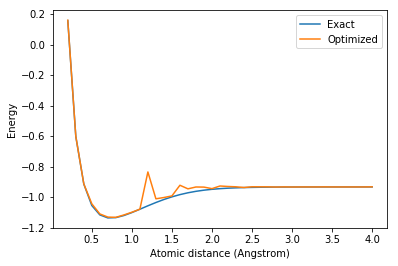

In [9]:
plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
if run_optimization:
    plt.plot(mol_distance,electr_energy_optimized+coulomb_repulsion,label='Optimized') 
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()